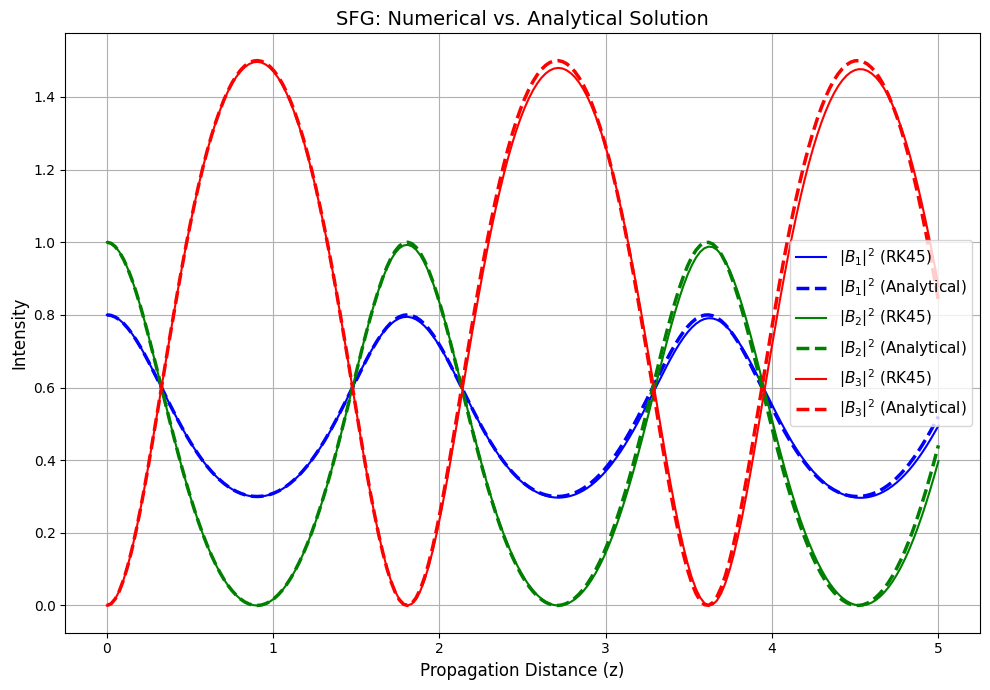

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.special import ellipj, ellipkinc
import matplotlib.pyplot as plt

# --- 1. System Definition & Numerical Solution ---
KAPPA = 1.0
B0 = np.sqrt([0.8, 1.0, 1e-6]) * np.exp(1j * np.array([0.0, 0.0, 0.0]))
z_span = [0, 5]
z_eval = np.linspace(z_span[0], z_span[1], 200)


def sfg_ode(z, B, k):
    """Coupled-wave ODEs for SFG."""
    B1, B2, B3 = B
    return np.array([
        1j * k * np.conj(B2) * B3,
        1j * 2 * k * np.conj(B1) * B3,
        1j * 3 * k * B1 * B2
    ])


sol_numerical = solve_ivp(
    sfg_ode, z_span, B0, args=(KAPPA,), dense_output=True, t_eval=z_eval
)
I_numerical = np.abs(sol_numerical.y)**2

# --- 2. Analytical Solution ---


def solve_analytical_intensity(z_points, B0_init, k):
    """Calculates intensities using the analytical Jacobi elliptic function solution."""
    I0 = np.abs(B0_init)**2
    phi0 = np.angle(B0_init)

    # Manley-Rowe invariants
    M1 = 2 * I0[0] - I0[1]
    M2 = 3 * I0[0] + I0[2]

    # Conserved quantity K_sfg and polynomial roots
    K_sfg = 2 * k * np.sqrt(np.prod(I0)) * np.cos(phi0[2] - phi0[1] - phi0[0])
    k_sq = k**2
    poly_coeffs = [
        -24 * k_sq,
        4 * k_sq * (2 * M2 + 3 * M1),
        -4 * k_sq * M1 * M2,
        -K_sfg**2
    ]
    u1, u2, u3 = np.sort(np.real(np.roots(poly_coeffs)))[::-1]

    # Elliptic parameters and phase offset z0
    Omega = k * np.sqrt(6 * (u1 - u3))
    m = (u1 - u2) / (u1 - u3 + 1e-15)
    sn_arg = np.clip(
        np.sqrt(np.maximum(0, (u1 - I0[0]) / (u1 - u2 + 1e-15))), -1.0, 1.0)
    z0 = -ellipkinc(np.arcsin(sn_arg), m) / Omega

    # Calculate intensities from cn^2(z) solution
    _, cn_vals, _, _ = ellipj(Omega * (z_points - z0), m)
    I1 = u2 + (u1 - u2) * cn_vals**2
    return np.array([I1, 2 * I1 - M1, -3 * I1 + M2])


I_analytical = solve_analytical_intensity(z_eval, B0, KAPPA)

# --- 3. Visualization & Verification ---
fig, ax = plt.subplots(figsize=(10, 7))

colors = ['b', 'g', 'r']
labels = ['$|B_1|^2$', '$|B_2|^2$', '$|B_3|^2$']
for i in range(3):
    ax.plot(z_eval, I_numerical[i],
            f'{colors[i]}-', label=f'{labels[i]} (RK45)')
    ax.plot(z_eval, I_analytical[i], f'{colors[i]}--',
            lw=2.5, label=f'{labels[i]} (Analytical)')

ax.set_xlabel("Propagation Distance (z)", fontsize=12)
ax.set_ylabel("Intensity", fontsize=12)
ax.set_title("SFG: Numerical vs. Analytical Solution", fontsize=14)
ax.legend(fontsize=11, loc='center right')
ax.grid(True)
plt.tight_layout()
plt.show()